# RNN

resource : https://colah.github.io/posts/2015-08-Understanding-LSTMs/

1. Load the extrasensory dataset

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

from utilize.data import *
from utilize.transform import *
from utilize.feature_selection import *
from utilize.test import *

Found 60 users data.


In [2]:
def score_function(y_test, y_pred, score = 'BA', W_test = None):

    mcm = []
    for i in range(y_test.shape[1]):
        if W_test is not None:
            cm = confusion_matrix(y_test[:,i].T, y_pred[:,i].T, sample_weight = W_test[:,i].T)
        else:
            cm = confusion_matrix(y_test[:,i].T, y_pred[:,i].T)
        cm = np.expand_dims(cm, axis = 0)
        mcm.append(cm)
    
    mcm = np.concatenate(mcm, axis = 0)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    BA = (sensitivity + specificity)/2
    accuracy = (tn + tp)/(tn + tp + fn + fp)

    sensitivity = np.sum(sensitivity)/sensitivity.shape[0]
    specificity = np.sum(specificity)/specificity.shape[0]
    BA = np.sum(BA)/BA.shape[0]
    accuracy = np.sum(accuracy)/accuracy.shape[0]

    if score == 'BA': 
        return BA
    else: 
        raise Exception('score not valid!')

In [3]:
# Load all the data from Extrasenory dataset
X, y, M, user_index, feature_names, label_names = load_all_data()

In [4]:
feature_index = [ 0,   1,   2,   4,   6,   7,   9,  12,  13,  16,  17,  18,  19,
        20,  22,  23,  24,  25,  26,  27,  28,  31,  32,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  49,  52,  53,
        54,  56,  58,  59,  60,  61,  62,  63,  65,  67,  68,  69,  71,
        72,  73,  74,  76,  77,  78,  79,  80,  81,  85,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 119, 120,
       121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150,
       151, 153, 154, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 170, 171, 172, 173, 176, 177, 178, 180, 181, 182, 183,
       185, 187, 188, 190, 192, 193, 194, 195, 196, 197, 198, 199, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 224]
X175 = X[:, feature_index]

In [5]:
# Only select body state label
#target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
target_label = ["SITTING"]
# Use the last 5 user's data as test set
#test_uuid = list(range(56, 61))

# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('std_scaler', StandardScaler())
])

# Transform 
# 1. select target labels 
# 2. tansform feature matrix fill None with mean and do the normalization
# 3. Split train, validation and test set by ratio of 6:2:2
X_new, y_new, M_new = select_target_labels(X175, y, M, target_label, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)
X_train, y_train, M_train, X_val, y_val, M_val, X_test, y_test, M_test = random_split(X_new, y_new, M_new, test_size = 0.2, val_size = 0.2, random_seed = 42)

In [6]:
# To swap 0 and 1, simply do 
y_train_sampleweight = np.abs(1-M_train)

y_train_sw1D = np.zeros(y_train_sampleweight.shape[0])
for i in range(len(y_train_sw1D)):
    y_train_sw1D[i] = np.sum(y_train_sampleweight[i])/M_train.shape[1]

# To swap 0 and 1, simply do 
y_test_sampleweight = np.abs(1-M_test)

y_test_sw1D = np.zeros(y_test_sampleweight.shape[0])
for i in range(len(y_test_sw1D)):
    y_test_sw1D[i] = np.sum(y_test_sampleweight[i])/M_test.shape[1]

# RNN model

In [7]:
import warnings
warnings.simplefilter("ignore")

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM

In [9]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(226408, 175) (75469, 175)
(226408, 1) (75469, 1)


In [18]:
batch_size = 16

model_1 = Sequential()
# Fully-connected layer
model_1.add(Dense(1, input_shape = (X_train.shape[1],), activation = "sigmoid"))
model_1.add(Dropout(0.2))
model_1.compile(loss = "binary_crossentropy", #tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'sgd',
              metrics = ['accuracy'])

# fit network
model = model_1.fit(X_train, y_train,
                      epochs = 10, 
                      batch_size = 16,
                      validation_data = (X_test, y_test), 
                      sample_weight = y_train_sw1D)

Train on 226408 samples, validate on 75469 samples
Epoch 1/10
226408/226408 [==============================] - 16s 69us/sample - loss: 4.3866 - acc: 0.6124 - val_loss: 5.0879 - val_acc: 0.6319
Epoch 2/10
226408/226408 [==============================] - 14s 63us/sample - loss: 4.0164 - acc: 0.6451 - val_loss: 4.6564 - val_acc: 0.6612
Epoch 3/10
226408/226408 [==============================] - 14s 60us/sample - loss: 3.7040 - acc: 0.6646 - val_loss: 4.3939 - val_acc: 0.6808
Epoch 4/10
226408/226408 [==============================] - 13s 59us/sample - loss: 3.5481 - acc: 0.6752 - val_loss: 4.2989 - val_acc: 0.6891
Epoch 5/10
226408/226408 [==============================] - 13s 57us/sample - loss: 3.4897 - acc: 0.6789 - val_loss: 4.2547 - val_acc: 0.6922
Epoch 6/10
226408/226408 [==============================] - 13s 55us/sample - loss: 3.4437 - acc: 0.6803 - val_loss: 4.2250 - val_acc: 0.6936
Epoch 7/10
226408/226408 [==============================] - 15s 67us/sample - loss: 3.3848 - acc:

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app
C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


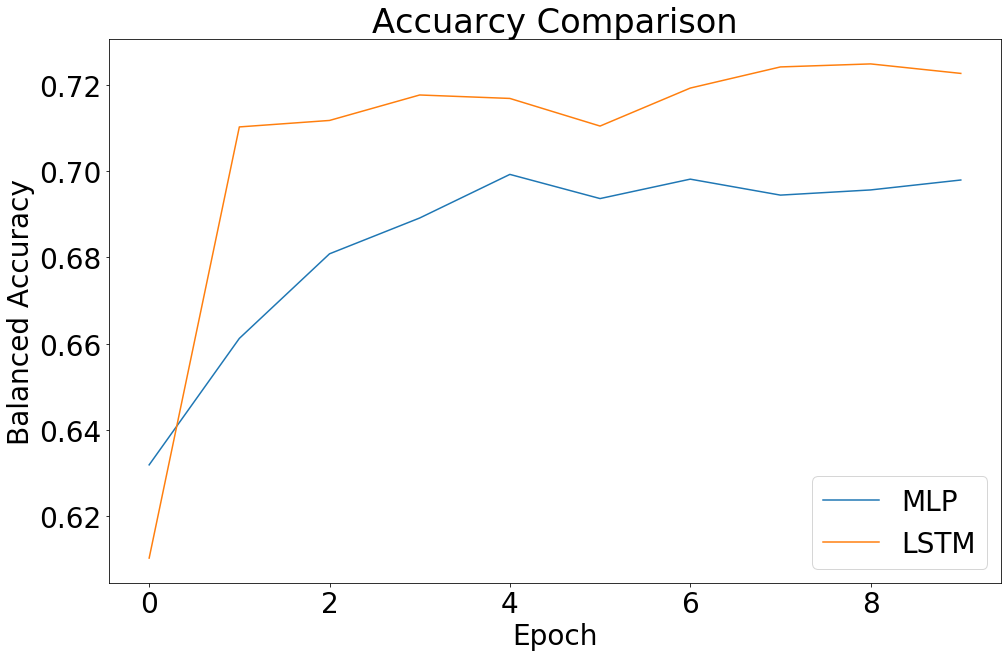

In [11]:
# Plot training & validation accuracy
#plt.plot(score_rnn)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
plt.rc('font', **font)
fig = plt.figure(figsize = (16, 10))
score_1 = [0.6319, 0.6612, 0.6808, 0.6891, 0.6992, 0.6936, 0.6981, 0.6944, 0.6956, 0.6979]
score_2 = [0.6103, 0.7102, 0.7117, 0.7176, 0.7168, 0.7174, 0.7192, 0.7241, 0.7248, 0.7126]
plt.plot(score_1)
plt.plot(score_2)
plt.ylabel('Balanced Accuracy')
plt.title("Accuarcy Comparison")
plt.xlabel('Epoch')
plt.legend(["MLP", "LSTM"], loc = 'bottom right')
fig.show()

# LSTM model

In [20]:
# [samples, time_steps, features]
X_train_1 = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_1 = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
hidden_size = 1
time_step = 1

model_2 = Sequential()
model_2.add(LSTM(1, batch_input_shape = (hidden_size, time_step, X_train_1.shape[2]),
              activation = "sigmoid"))
model_2.add(Dropout(0.2))
model_2.compile(loss = "binary_crossentropy",
              optimizer = 'sgd',
              metrics = ['accuracy'])

# fit network
model_lstm = model_2.fit(X_train_1, y_train,
                         epochs = 10,
                         batch_size = 1, 
                         validation_data = (X_test_1, y_test),
                         sample_weight = y_train_sw1D)

Train on 226408 samples, validate on 75469 samples
Epoch 1/10
226408/226408 [==============================] - 412s 2ms/sample - loss: 2.0760 - acc: 0.6265 - val_loss: 0.9030 - val_acc: 0.7003
Epoch 2/10
226408/226408 [==============================] - 408s 2ms/sample - loss: 3.2100 - acc: 0.5562 - val_loss: 3.0696 - val_acc: 0.6012
Epoch 3/10
226408/226408 [==============================] - 409s 2ms/sample - loss: 3.4995 - acc: 0.5425 - val_loss: 3.0211 - val_acc: 0.6117
Epoch 4/10
226408/226408 [==============================] - 406s 2ms/sample - loss: 3.4290 - acc: 0.5505 - val_loss: 2.9191 - val_acc: 0.6216
Epoch 5/10
226408/226408 [==============================] - 406s 2ms/sample - loss: 3.3674 - acc: 0.5535 - val_loss: 2.8610 - val_acc: 0.6268
Epoch 6/10
137695/226408 [=================>............] - ETA: 2:17 - loss: 3.3323 - acc: 0.5568

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002B59FEE8A88>>


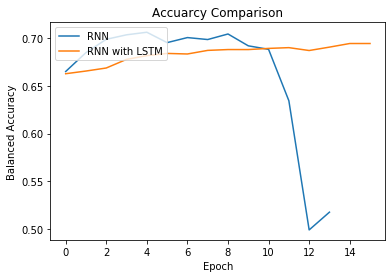

In [71]:
# Plot training & validation accuracy
#plt.plot(score_rnn)
list_lstm = model_lstm.history['val_acc'] + [0.6942]
list_rnn = model.history["acc"]

fig = plt.figure(figsize = (16, 10))
plt.plot(model.history['acc'])
plt.plot(list[1:])
plt.ylabel('Balanced Accuracy')
plt.xlabel('Epoch')
fig.show()

In [ ]:
plt.plot(model_rnn.history['val_acc'], "RNN")
plt.plot(model_lstm.history['val_acc'], "RNN with LSTM")
plt.title("Accuarcy Comparison")
plt.ylabel('Balanced Accuracy')
plt.xlabel('Epoch')
plt.legend(['RNN', 'RNN with LSTM'], loc = 'upper left')
plt.show()